# Introduction + Background

The following analyses were part of my Ph.D thesis trying to understand the influence connections have on long-term recovery. I hypothesized that lesioned regions that possess greater inter-hemispheric connections are more likely to undergo recovery over the long term. This would through compensation through the lesioned region's mirrored region. This mirrored region is called the homotopic region and together both regions are a homotopic pair. Homotopic pairs are more likely to 

While I conducted analyses on other graph metrics, in this notebook I focus only on the participation coefficient.  Participation coefficients measure the diversity of connections a particular region has. Diversity is defined as the distribution of connections across different modules or groups of regions. Below is a cartoon depicting the participation coefficient   
Based on the Participation coefficient I modify it such that I remove the inter-hemispheric connections and recalculate the coefficient. Then the coefficient indicates which regions experience the greatest loss in diversty stemming from the loss of inter-hemispheric connections.

These analyses are intended to validate the coefficient. If the coefficient is suppose to reflect the extent of inter-hemispheric connectivity for a region, then it should also reflect some other properties important for mediating the communication between hemispheres. Based on these properties I then conduct further analyses. 
Below is a jupyter notebook containing the code for some analyses related .


Because characterizing the connections from fMRI scans is super complex (and something I know only a fraction about) I'm going to skip any of the preprocessing steps on the 'raw' data. Instead, I'll start with a 246 x 246 connection matrix, that I've processed already) containing  246 cortical regions of interest along the rows and column. Entries contain the streamline or an estimate of the axonal density connecting the two regions. Plotting this connection matrix results in something that looks like this: 

Because there's alot of code going into these analyses I tried to bury as much as I could into functions that could be tucked away for easier reading. I provde short descriptions of each function.

### Load Libraries

In [450]:
import os
import re
import copy
import pickle
from itertools import compress

import numpy as np
import pandas as pd
import scipy
from scipy.io import savemat, loadmat

import networkx as nx
import infomap

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nilearn.image import load_img, new_img_like
import nilearn.plotting as plotting
import hcp_utils as hcp

from sklearn import decomposition
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.evaluate import permutation_test

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")


### Define Global Utility Functions


In [296]:
def odds(l):
    return [x for x in l if x & 1]

def even(l):
    return [x for x in l if not x & 1]

def read_term_list(path):
    with open(path, 'r') as f:
        terms = f.read().splitlines()
    return terms

def load_nii_to_array(path):
    return load_img(path).get_fdata()

def build_graphs(white_matter):
    G = {
        'b_hemisphere': nx.convert_matrix.from_numpy_array(white_matter),
        'l_hemisphere': nx.convert_matrix.from_numpy_array(white_matter),
        'r_hemisphere': nx.convert_matrix.from_numpy_array(white_matter)
    }
    node_range = range(np.shape(white_matter)[0])
    G['l_hemisphere'].remove_nodes_from(node for node in node_range if node % 2 == 1)
    G['r_hemisphere'].remove_nodes_from(node for node in node_range if node % 2 == 0)
    return G

def read_gifti_label(file_path):
    gifti_label = nib.load(file_path)
    return np.array([x.data for x in gifti_label.darrays][0]).astype(float)

def update_gifti_label(data, gifti_label):
    for parcels, val in enumerate(data):
        gifti_label[gifti_label == parcels + 1] = val
    return gifti_label


### Load Data Files

In [354]:
subjects = open('./s900_unrelated.txt').read().splitlines()[:97]

connectome = loadmat('./BN_MRtrix3_98_15.mat')
m_connectome, g_connectome = connectome['m_connectome'], connectome['g_connectome']

centers = np.genfromtxt('./centers.txt', delimiter='\t', usecols=(1, 2, 3))

unformat_regions = open('./region_labels.txt').read().splitlines()
regions = {i * 2: re.sub('\s+', '', region) for i, region in enumerate(unformat_regions)}
regions.update({i * 2 + 1: re.sub('\s+', '', region) for i, region in enumerate(unformat_regions)})

term_list = read_term_list('./NeuroSynth/terms.txt')
parcellation = load_nii_to_array('./BN_Atlas_246_2mm.nii')

resting = loadmat('./label_index.mat')['label_index']
resting_indices = [np.where(resting == resting)[0] for resting in np.arange(1, 8)]

# 
with open('./individual_participation_coefficient.pkl', 'rb') as fp:
    individual_participation_coefficient = pickle.load(fp)

individual_participation_coef = {}
individual_participation_coef['normal'] = individual_participation_coefficient['normals']['participation']
individual_participation_coef['lateral'] = individual_participation_coefficient['lateral']['participation']

network_names = ['Dorsal Attention', 'Ventral Attention', 'Limbic', 'Frontoparietal', 'Default', 'Somatomotor', 'Visual']
network_abbrev = ['DAN', 'VAN', 'SAN', 'FPN', 'DMN', 'Som', 'Vis']

### Set Global Plotting Parameters


In [522]:
# Define font properties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

# Define math text properties
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'sans'
plt.rcParams['mathtext.it'] = 'sans:italic'
plt.rcParams['mathtext.default'] = 'it'

# Define sizes for different elements
small_size = 12
medium_size = 16
large_size = 20

plt.rc('font', size = small_size)          # controls default text sizes
plt.rc('axes', titlesize = small_size)     # fontsize of the axes title
plt.rc('axes', labelsize = medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize = small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize = small_size)    # legend fontsize
plt.rc('figure', titlesize = large_size)   # fontsize of the figure title

# Properties of Whole-Brain and the corresponding Hemispheric participation coefficients are dissimilar

This section is the 'EDA' portion of my analyses. It focuses on visualizing the properties of the Hm participation coefficients and comparing them to the WB coefficients. These simple analyses are necessary as the Hm coefficients are derived from the WB coefficients. This dependence could result in future findings stemming from shared properties/similarities between Hm and WB coefficients. Therefore, a common theme in all following analyses in the constant application of analyses to both Hm and WB coefficients and the comparisons. 

### Section Specific Utility + Plotting Functions

In [ ]:
def participation_coefficient(W, ci, degree = 'undirected'):
    if degree == 'in':
        W = W.T

    _, ci = np.unique(ci, return_inverse=True)
    ci += 1
    
    n = len(W)  # number of vertices
    Ko = np.sum(W, axis = 1)  # (out) degree
    Gc = np.dot((W != 0), np.diag(ci))  # neighbor community affiliation
    Kc2 = np.zeros((n,))  # community-specific neighbors

    for i in range(1, int(np.max(ci)) + 1):
        Kc2 += np.square(np.sum(W * (Gc == i), axis=1))

    P = np.ones((n,)) - Kc2 / np.square(Ko)
    # P=0 if for nodes with no (out) neighbors
    P[np.where(np.logical_not(Ko))] = 0

    return P


def infomap_partitions(G, white_matter):
    
    partition = np.zeros(G.number_of_nodes(), dtype=int)

    infomap_wrapper = infomap.Infomap("--two-level --silent")

    for e in G.edges(data=True):
        infomap_wrapper.addLink(*e[0:2], e[2].get('weight', 1))

    infomap_wrapper.run()

    for node, module in infomap_wrapper.modules:
        partition[node] = module

    modules = {}
    communities = []

    for node in G.nodes():
        module = partition[node]
        if module not in modules:
            modules[module] = []
        modules[module].append(node)

    for module_nodes in modules.values():
        communities.append(set(module_nodes))

    participation = np.array(list(participation_coefficient(white_matter, partition)))

    return modules, communities, participation, partition

def partition_graphs(G):
    partition = {'b_hemisphere': infomap_partitions(G['b_hemisphere'])[0]}
    partition['l_hemisphere'] = {k: even(v) for k, v in partition['b_hemisphere'].items()}
    partition['r_hemisphere'] = {k: odds(v) for k, v in partition['b_hemisphere'].items()}
    return partition

def calculate_indices(G, white_matter, partition):
    b_hemisphere = participation_coefficient(G['b_hemisphere'], partition['b_hemisphere'])
    l_hemisphere = participation_coefficient(G['l_hemisphere'], partition['l_hemisphere'])
    r_hemisphere = participation_coefficient(G['r_hemisphere'], partition['r_hemisphere'])

    normal_indices = [b_hemisphere.get(node, 0) for node in range(np.shape(white_matter)[0])]
    lateral_indices = [calculate_lateral_index(b_hemisphere, l_hemisphere, r_hemisphere, entry) for entry in b_hemisphere.items()]
    
    return normal_indices, lateral_indices

def sort_indices(indices, return_number):
    sorted_indices = sorted(range(len(indices)), key=indices.__getitem__)
    return sorted_indices[:return_number], sorted_indices[-return_number:]

def calculate_lateral_participation_coefficient(white_matter, return_number = 210):
    G = {'b_hemisphere' : nx.convert_matrix.from_numpy_array(white_matter)}
    l_hemisphere, r_hemisphere = white_matter.copy(), white_matter.copy()
    l_hemisphere[1::2, :], l_hemisphere[:, 1::2] = 0, 0
    r_hemisphere[::2, :], r_hemisphere[:, ::2] = 0, 0

    partition = infomap_partitions(G['b_hemisphere'], white_matter)[3]
    
    b_participation, l_participation, r_participation = participation_coefficient(white_matter, partition), participation_coefficient(l_hemisphere, partition), participation_coefficient(r_hemisphere, partition)

    normal_indices, lateral_indices = b_participation.copy(), (b_participation - l_participation - r_participation).copy()

    sorted_indices = lambda indices: sorted(range(len(indices)), key = indices.__getitem__)

    return normal_indices, lateral_indices, sort_indices(normal_indices, return_number), sort_indices(lateral_indices, return_number)

In [454]:
def create_mesh_settings(left_gifti, right_gifti):
    return [{'mesh': hcp.mesh.inflated_left, 'roi_map': left_gifti, 'hemi': 'left', 'bg_map': hcp.mesh.sulc_left},
            {'mesh': hcp.mesh.inflated_left, 'roi_map': left_gifti, 'hemi': 'left', 'bg_map': hcp.mesh.sulc_left},
            {'mesh': hcp.mesh.inflated_right, 'roi_map': right_gifti, 'hemi': 'right', 'bg_map': hcp.mesh.sulc_right},
            {'mesh': hcp.mesh.inflated_right, 'roi_map': right_gifti, 'hemi': 'right', 'bg_map': hcp.mesh.sulc_right}]

def draw_graph(data, G, regions, ax):
    pos = nx.spring_layout(G, k = 0.25, weight = 'weight', seed = 14000)
    edgecolors = ['tab:blue'] * 68 + ['tab:orange'] * 56 + ['tab:green'] * 38 + ['tab:red'] * 12 + ['tab:purple'] * 14 + ['tab:brown'] * 22
    cmap = copy.copy(plt.get_cmap('viridis'))
    cmap.set_under('ivory')
    G_wghts = [G[u][v]['weight'] for u,v in G.edges()]

    nx.draw_networkx(G, pos, node_size=200, width=np.multiply(G_wghts, 0.25), edge_color='gray', node_color=data, cmap=cmap, labels=regions, font_size=36, font_weight='bold', font_family='Arial', ax=ax, vmin=np.percentile(data, 80))

    nx.draw_networkx_nodes(G, pos, node_size=200, node_color=data, cmap=cmap, ax=ax, vmin=np.percentile(data, 80), linewidths=2, edgecolors=edgecolors)

def plott_surfaces_with_networks(data, connectome, regions, title):
    l_gifti_label = read_gifti_label('../../MRtrix3_connectome/BN_Atlas_freesurfer/fsaverage/32k/fsaverage.L.BN_Atlas.32k_fs_LR.label.gii')
    r_gifti_label = read_gifti_label('../../MRtrix3_connectome/BN_Atlas_freesurfer/fsaverage/32k/fsaverage.R.BN_Atlas.32k_fs_LR.label.gii')

    l_gifti_label = update_gifti_label(data, l_gifti_label)
    r_gifti_label = update_gifti_label(data, r_gifti_label)

    fig, axs = plt.subplots(4, 2, figsize = (9, 18))
    fig.subplots_adjust(hspace = 0.0001, wspace = 0.0001)
    axs = axs.ravel()

    mesh_settings = create_mesh_settings(l_gifti_label, r_gifti_label)
    view_settings = ['lateral', 'medial', 'medial', 'lateral']

    for subplot, (mesh_setting, view) in enumerate(zip(mesh_settings, view_settings)):
        ax = axs[subplot]
        ax.remove()
        ax = fig.add_subplot(4, 2, subplot + 1, projection = '3d')
        cmap = plt.get_cmap('viridis')
        cmap.set_under('dimgray')

        plotting.plot_surf_roi(surf_mesh=mesh_setting['mesh'], roi_map=mesh_setting['roi_map'], hemi=mesh_setting['hemi'], view=view, bg_map=mesh_setting['bg_map'], bg_on_data=True, darkness=.2, cmap=cmap, axes=ax, colorbar=True, cbar_tick_format='%f', vmin=min(data[data > 0]), vmax=max(data))

    ax = plt.subplot2grid(shape=(4, 2), loc=(2, 0), rowspan=2, colspan=2)
    connectome[connectome < np.percentile(connectome, 95)] = 0
    G = nx.convert_matrix.from_numpy_array(connectome)
    
    filter_regions = [data > np.percentile(data, 80)]
    filter_regions = list(compress(range(len(data)), filter_regions[0]))
    regions = {key: regions[key] for key in filter_regions}

    draw_graph(data, G, regions, ax)
    ax.axis("off")
    plt.show()

def add_significance_bar(axes, p_value, network):
    y, h = 18., 0.5
    x = network
    axes.plot([x - 0.25, x - 0.25, x + 0.25, x + 0.25], [y, y + h, y + h, y], lw = 2, c = 'k')
    axes.text(x, y + h, "*", ha = 'center', va = 'bottom', fontsize = 16, fontweight = 'bold', color = 'k')


## Analyses

Both Hm and WB coefficients are calculated using the connection matrix ```white_matter```. Module are estimated using the infomap algorithm that is a well-validated for grouping regions.

In [297]:
participation_coef = {'normal': None, 'lateral': None}

white_matter = m_connectome

participation_coef['normal'], participation_coef['lateral'], _, _, = calculate_lateral_participation_coefficient(white_matter)

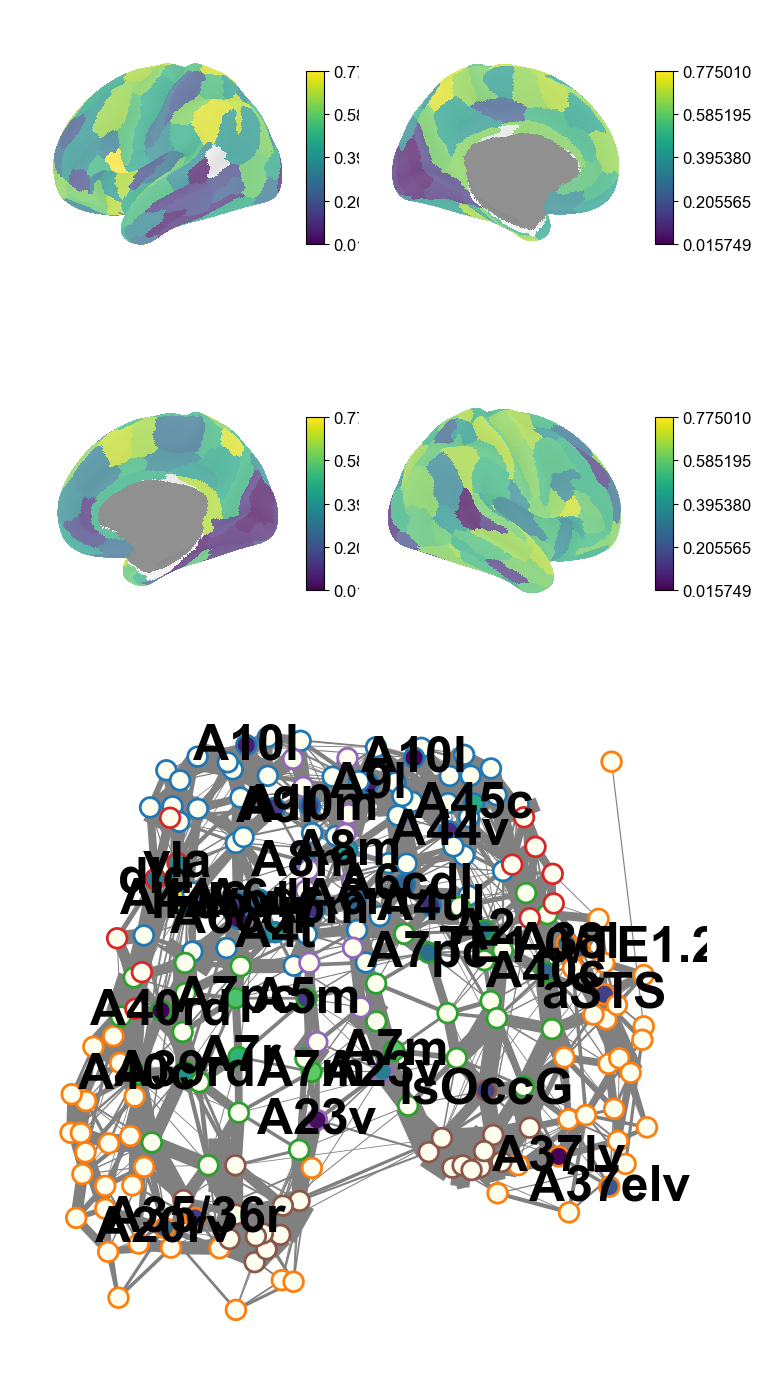

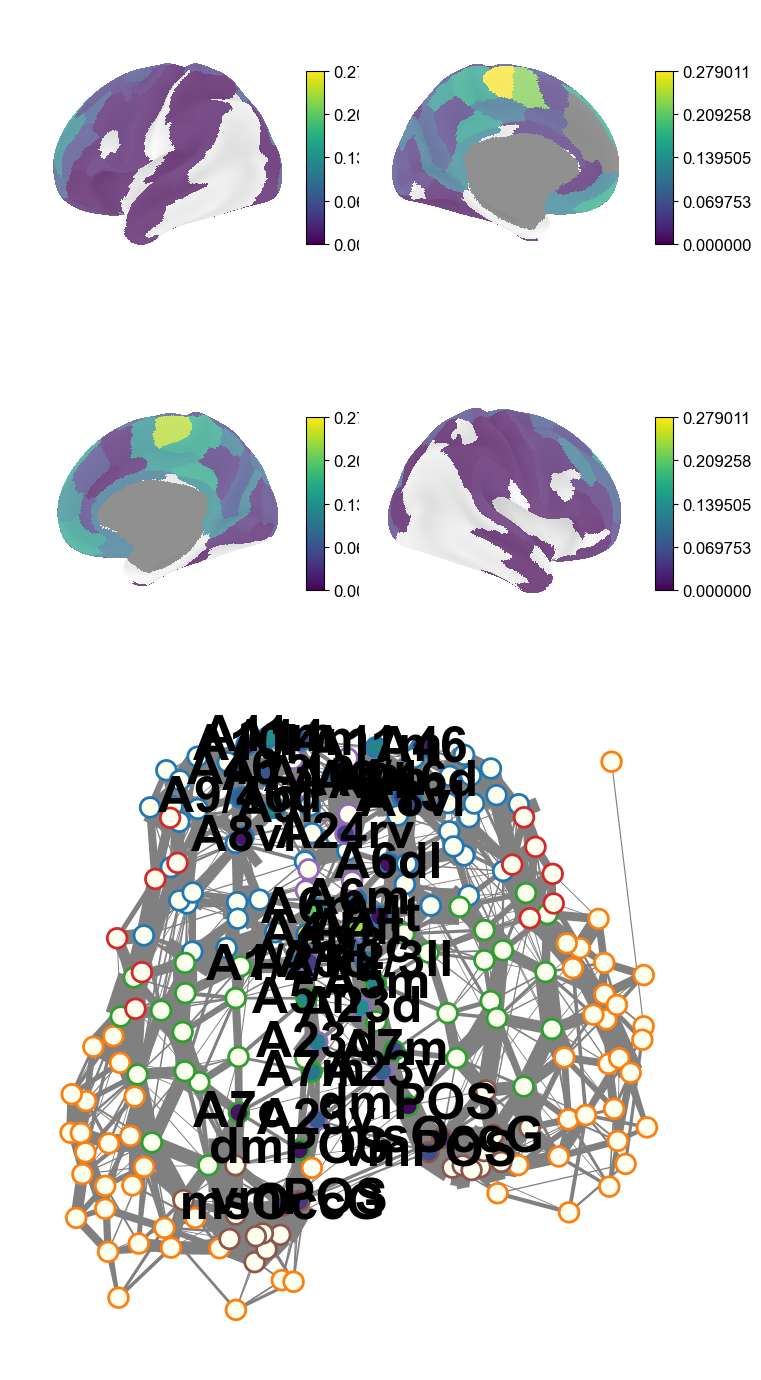

In [251]:
plott_surfaces_with_networks(participation_coef['normal'], copy.deepcopy(m_connectome), copy.deepcopy(regions), 'Participation Coefficient - Hemispheric')
plott_surfaces_with_networks(participation_coef['lateral'], copy.deepcopy(m_connectome), copy.deepcopy(regions), 'Participation Coefficient - Whole-Brain')

Hm and WB coefficients are projected onto the cortical surface. 

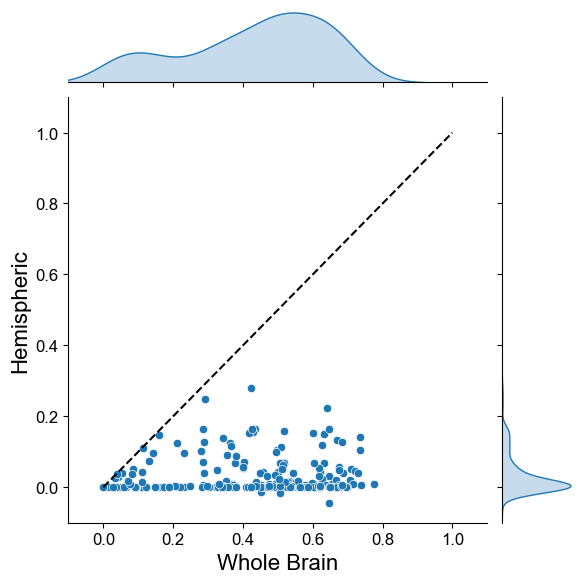

In [523]:
df = pd.DataFrame({
    'Whole-Brain': participation_coef['normal'],
    'Hemispheric': participation_coef['lateral']
})

plot = sns.jointplot(data=df, x='Whole-Brain', y='Hemispheric', fill=True, kind='kde', 
                     joint_kws={'alpha': 0}, legend=False,
                     xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

plot.plot_joint(sns.scatterplot)

plot.ax_joint.set_xlabel('Whole Brain')
plot.ax_joint.set_ylabel('Hemispheric')

limits = [max(*plot.ax_joint.get_xlim(), *plot.ax_joint.get_ylim()), min(*plot.ax_joint.get_xlim(), *plot.ax_joint.get_ylim())]
plot.ax_joint.plot([0,1], [0,1], '--k')


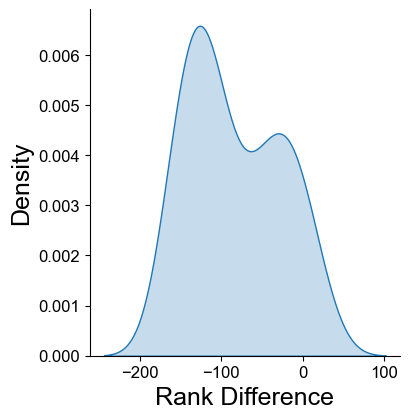

In [524]:
sorted_normal = np.argsort(participation_coef['normal'])
sorted_lateral = np.argsort(participation_coef['lateral'])

difference = np.array([np.where(sorted_normal == rank)[0][0] - np.where(sorted_lateral == rank)[0][0] for rank in range(210)])

sliced_difference = difference.flatten()[sorted_lateral[-42:]]

hubs = pd.DataFrame(data={'Rank Difference': sliced_difference, 'Measure': ['Participation'] * 42})

plt.figure(figsize=(4, 4.5))
plot = sns.kdeplot(data=hubs, x='Rank Difference', fill=True)
sns.despine()

plot.set_xlabel('Rank Difference')
plot.set_ylabel('Density')
plt.show()

**Background**: Node importance has been found to correlate significantly with long-term outcomes. Lesions to important nodes result to greater deficits to behavior. Comparing the relative importance of nodes between Hm and WB coefficients offers another means of understanding
Comparisons are conduct by simply taking the difference between the Hm and WB coefficient rank for each nodes

**Results**: Our analyses find a significant shift in the 

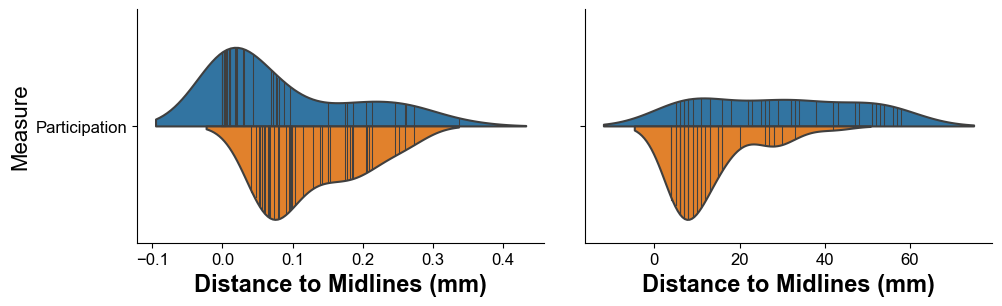

In [525]:
contralateral_indices = [np.arange(1, 210, 2), np.arange(0, 210, 2)]
prop_contralateral = [np.sum(m_connectome[node, contralateral_indices[node%2]]) / np.sum(m_connectome[node]) for node in range(210)]

normal_data = np.squeeze(prop_contralateral)[np.squeeze(sorted_normal[-42:])]
lateral_data = np.squeeze(prop_contralateral)[np.squeeze(sorted_lateral[-42:])]
midline_normal_data = np.squeeze(midline)[np.squeeze(sorted_normal[-42:])]
midline_lateral_data = np.squeeze(midline)[np.squeeze(sorted_lateral[-42:])]

data = np.concatenate([normal_data, lateral_data, midline_normal_data, midline_lateral_data])

hubs = pd.DataFrame({
    'data': data, 
    'Measure': ['Participation'] * 168,
    'Shift': ['Proportion Contralateral'] * 84 + ['Distance to Midline'] * 84,
    'Laterality': ['Whole Brain'] * 42 + ['Hemispheric'] * 42 + ['Whole Brain'] * 42 + ['Hemispheric'] * 42
})

plot = sns.catplot(
    y="Measure", 
    x="data", 
    hue="Laterality", 
    col="Shift",
    kind="violin", 
    inner="stick", 
    split=True,
    data=hubs, 
    sharex=False
)

plot.fig.set_size_inches(12, 3)
plt.subplots_adjust(wspace=0.1)
plot._legend.remove()

for ax in plot.axes.flat:
    ax.set_title('')
    # ax.spines['left'].set_visible(False)
    # ax.set_yticklabels('', fontsize=17, fontweight='bold')
    # ax.set_ylabel('', fontsize=17, fontweight='bold')
    ax.set_xlabel('Proportion Contralateral Streamlines' if 'Contralateral' in ax.get_xlabel() else 'Distance to Midlines (mm)', fontsize=17, fontweight='bold')
    # ax.tick_params(axis='y', which='both', length=0)


**Background**: We extend our analyses to the spatial properties of important Hm and WB nodes. Contralateral streamlines refers to the axons that start and end in different hemispheres. Streamlines are an estimate of axonal density. Therefore, calulating the proportion estimates the ratio of    
Distance to midline estimates the space between a region and the midline separating both hemispheres.
Understanding these properties sheds some 

**Result**


In [362]:
hubs = {key: np.zeros((len(subjects), 210)) for key in ['lateral', 'normal']}
statistic = {key: np.zeros((len(subjects), 7)) for key in ['chis', 'pval']}
contingency = {str(i): np.zeros((2, 2, len(subjects))) for i in range(7)}
overlap = pd.DataFrame()

for i, subject in enumerate(subjects):
    
    for lateral in ['lateral', 'normal']:
        hubs[lateral][i, individual_participation_coef[lateral][i,:] > np.percentile(individual_participation_coef[lateral][i,:], 80)] = 1

    for network in range(7):
        network_index = network_indices[network]
        lateral_network = np.squeeze(hubs['lateral'][i, network_index])
        normals_network = np.squeeze(hubs['normal'][i, network_index])

        overlaps = len(np.intersect1d(np.where(normals_network == 1), np.where(lateral_network == 1)))
        overlap = pd.concat([overlap, pd.DataFrame(data = {'overlap': int(overlaps), 'network': network_names[network], 'subject': subject}, index = [i])], ignore_index=True)
        overlap.loc[i, 'overlap'] = overlaps

        contingency[str(network)][0, 0, i] = np.sum(normals_network)
        contingency[str(network)][0, 1, i] = len(network_index) - contingency[str(network)][0, 0, i]
        contingency[str(network)][1, 0, i] = np.sum(lateral_network)
        contingency[str(network)][1, 1, i] = len(network_index) - contingency[str(network)][1, 0, i]

        try:
            chi2, pval, _, _ = scipy.stats.chi2_contingency(contingency[str(network)][:, :, i])
            statistic['chis'][i, network] = chi2
            statistic['pval'][i, network] = pval
        except:
            statistic['chis'][i, network] = 0
            statistic['pval'][i, network] = 1

Text(59.91016666666668, 0.5, 'Total Hub Count')

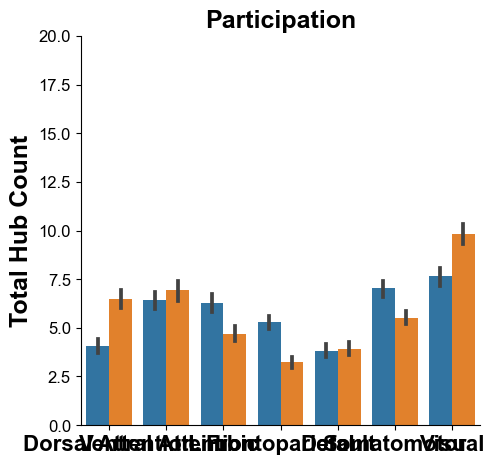

In [527]:
data = np.zeros((97 * 2 * 7, 1))
data[:,0] = np.hstack([contingency[str(i)][0, 0, :] for i in range(7)] + [contingency[str(i)][1, 0, :] for i in range(7)])

hubs = pd.DataFrame(data = data, columns = ['Counts'])
hubs['Measure'] = ['Participation'] * 97 * 14
hubs['Laterality'] = ['Hemispheric'] * 97 * 7 + ['Whole Brain'] * 97 * 7
hubs['Network'] = ['Dorsal Attention'] * 97 + ['Ventral Attention'] * 97 + ['Limbic'] * 97 + ['Frontoparietal'] * 97 + ['Default'] * 97 + ['Somatomotor'] * 97 + ['Visual'] * 97 + ['Dorsal Attention'] * 97 + ['Ventral Attention'] * 97 + ['Limbic'] * 97 + ['Frontoparietal'] * 97 + ['Default'] * 97 + ['Somatomotor'] * 97 + ['Visual'] * 97 

plot = sns.catplot(x = 'Network', y = 'Counts', col = 'Measure', hue = 'Laterality', kind = "bar", data = hubs)
plot._legend.remove()

axes = plot.axes
axes[0,0].set_title('Participation', fontsize = 18, fontweight = 'bold')
axes[0,0].set_xticklabels(network_labels, fontsize = 16, fontweight = 'bold', rotation = 0)
axes[0,0].set_xlabel('', fontsize = 0, fontweight = 'bold')
axes[0,0].set_ylim(0, 20)

for j, net in enumerate(network_names):
    hemispheric = hubs[(hubs['Measure'] == 'Participation') & (hubs['Laterality'] == 'Hemispheric') & (hubs['Network'] == net)]
    whole_brain = hubs[(hubs['Measure'] == 'Participation') & (hubs['Laterality'] == 'Whole Brain') & (hubs['Network'] == net)]
    p_value = scipy.stats.wilcoxon(hemispheric['Counts'], whole_brain['Counts'])[1]
    if p_value < 0.01:
        add_significance_bars(axes[0,0], p_value, j)
axes[0,0].set_ylabel('Total Hub Count', fontsize = 18, fontweight = 'bold')

**Background**: Lastly, 

# Hemispheric participation coefficients significantly predict the functional correlation between homotopic regional pairs.

Our previous analyses found that the Hm coefficient, collectively, is unique from the WB coefficient. We also found that some of its position 
However, the previous analyses focused on low-level phenomena distant from the behavioral outcomes I'm interested in. Therefore, the goal of this section is to relate the Hm coefficient to higher-level phenomena like cognition.
One prediction, stemming from the intended phenomena to be capture by the Hm-PC, is that Hm-PC should in some way scale with the hemispheric separation of function. Or at least scale more than WB-PC does. This is because 

This analysis relies on NeuroSynth, an open dataset, created by conducting meta-analyses on thousands of scientific publications. It collects 3D coordinates highlighting where the 

### Section Specific Utility + Plotting Functions

In [190]:
def process_images(term_list, parcellation):
    parcel = {}
    voxels = np.zeros((590, (91 * 109 * 91)))

    for i, term in enumerate(term_list):
        images_data = load_nii_to_array(f'./NeuroSynth/{term}/{term}_association-test_z_FDR_0.01_FWHM_6.nii.gz')
        parcel[term] = {str(roi): np.mean(images_data[parcellation == roi]) for roi in range(246)}
        voxels[i, :] = images_data.flatten()
    
    return voxels, parcel

def get_loadings(voxels, parcellation):
    parcels_loading = {}
    
    pca = decomposition.PCA()
    pca.fit(voxels)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_T = loadings.T

    for pc in range(590):
        reshape = np.reshape(loadings_T[pc,:], (91, 109, 91))
        parcels_loading[str(pc)] = {str(roi): np.mean(reshape[parcellation == roi]) for roi in range(246)}
    
    return loadings, parcels_loading

def perform_ols(df, conditions, formula=None):
    for condition in conditions:
        subset = df[eval(condition)]
    if formula:
        est = smf.ols(formula=formula, data=subset).fit()
    else:
        X = sm.add_constant(subset['Degree'])
        y = subset['Networked_Laterality']
        est = sm.OLS(y, X).fit()
    return est.resid

In [123]:
def plot_brain(loadings_T, axes,):
    reference = load_img('./NeuroSynth/acoustic/acoustic_association-test_z_FDR_0.01_FWHM_6.nii.gz')
    
    for i, ax in enumerate(axes):
        reshaped_loading = np.reshape(loadings_T[i,:], (91, 109, 91))
        # reshaped_loading = nib.Nifti1Image(reshaped_loading, reference.affine)
        reshaped_loading = new_img_like(reference, reshaped_loading)

        plotting.plot_glass_brain(reshaped_loading,
                                  title = ('PC' + str(i + 1)),
                                  display_mode = 'yz',
                                  threshold = None,
                                  annotate = False,
                                  axes = ax)    

def plotting_minkowski_surfaces(data):
    gifti_label = read_gifti_label('../../MRtrix3_connectome/BN_Atlas_freesurfer/fsaverage/32k/fsaverage.R.BN_Atlas.32k_fs_LR.label.gii')
    gifti_label = update_gifti_label(data, gifti_label)

    fig, axs = plt.subplots(1, 2, figsize = (10, 6))
    fig.subplots_adjust(hspace = 0.0001, wspace = 0.0001)
    axs = axs.ravel()

    for subplot, ax in enumerate(axs):
        cmap = copy.copy(plt.get_cmap('viridis'))
        cmap.set_bad('dimgray')
        cmap.set_under('dimgray')

        view = 'medial' if subplot in [1] else 'lateral'
        
        ax.remove()
        ax = fig.add_subplot(1, 2, subplot + 1, projection = '3d')

        plotting.plot_surf_roi(surf_mesh=hcp.mesh.inflated_left,
                           roi_map=gifti_label,
                           hemi='left', 
                           view=view,
                           bg_map=hcp.mesh.sulc_left,
                           bg_on_data=True,
                           darkness=.2,
                           cmap=cmap,
                           cbar_tick_format='%.2g',
                           colorbar=False,
                           axes=ax,
                           vmin=np.min(data), vmax=np.max(data))
    
    plt.show()


## Analysis

In [88]:
voxels, parcel = process_images(term_list, parcellation)
voxel_loadings, parcels_loading = get_loadings(voxels, parcellation)


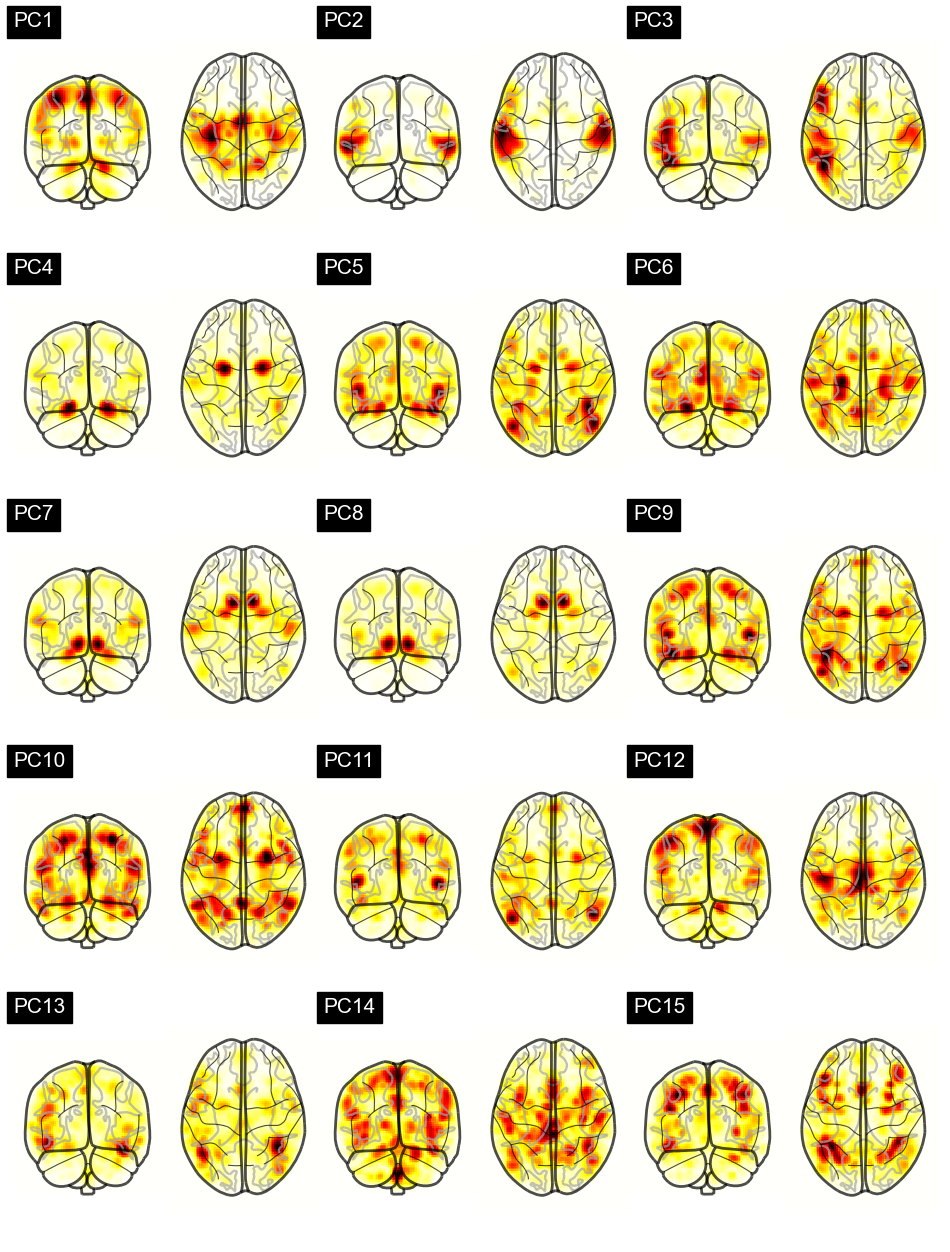

In [117]:
fig, axes = plt.subplots(5, 3, figsize = (12, 16))
fig.subplots_adjust(wspace = 0, hspace = 0)
axes = axes.ravel()

plot_brain(voxel_loadings.T, axes)
plt.subplots_adjust()
plt.show()

In [119]:
distance = np.zeros((2, 123))

for i, roi in enumerate(range(0, 246, 2)):
    homotopic = np.array([
        [parcels_loading[str(j)][str(k)]
         for j in range(15)]
        for k in [roi, roi + 1]
    ])

    distance[0, i] = scipy.spatial.distance.minkowski(homotopic[0], homotopic[1], p=1)

    minkowski = pd.DataFrame({
        'Loading': np.concatenate(homotopic),
        'PC': list(range(1, 16)) * 2,
        'Hemisphere': ['Left'] * 15 + ['Right'] * 15
    })

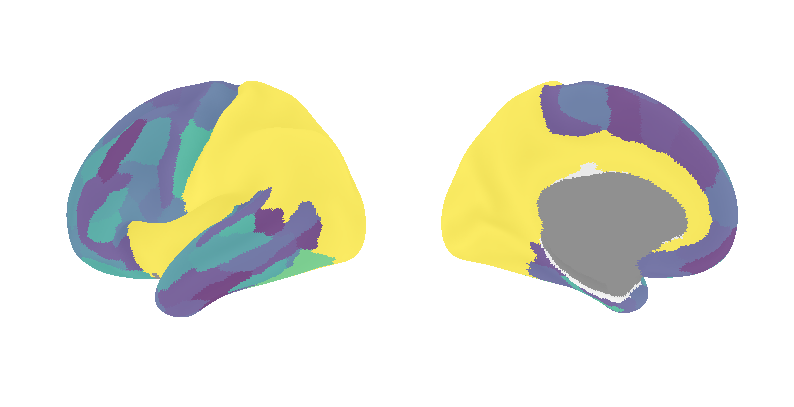

In [122]:
plotting_minkowski_surfaces(distance[0])

In [485]:
data = np.hstack((participation_coef['normal'], participation_coef['lateral']))

df = pd.DataFrame(data = data, columns = ['Networked_Laterality'])

G = nx.convert_matrix.from_numpy_array(m_connectome)
df['Degree'] = np.tile(np.array(list(nx.degree(G)))[:,1], 2)

df['Measure'] = ['Participation'] * 420
df['Hemisphere'] = ['Left', 'Right'] * 210
df['Laterality'] = ['Normal'] * 210 + ['Lateral'] * 210
df['Functional_Laterality'] = np.tile(distance[0, :105], 4)
df['Covariate'] = np.tile(participation_coef['normal'], 2)

unimodal_indices = np.array([8, 9, 52, 53, 56, 57, 58, 59, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 
                           104, 105, 106, 107, 110, 111, 112, 113, 118, 119, 130, 131, 134, 135, 
                           144, 145, 148, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 161, 
                           162, 163, 170, 171, 180, 181, 188, 189, 190, 191, 192, 193, 194, 195, 
                           196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209])
unimodal_indices = np.hstack((unimodal_indices, unimodal_indices + 210))
multimodal_indices = np.setdiff1d(range(420), unimodal_indices)

unidmodal_df = df.iloc[unimodal_indices]
multimodal_df = df.iloc[multimodal_indices]

In [191]:
conditions_formulas = [
    (("df['Laterality'] == 'Lateral'",), 'Functional_Laterality ~ Networked_Laterality + Covariate'),
    (("df['Laterality'] == 'Normal'",), None)
]

for conditions, formula in conditions_formulas:
    unimodal_regressed = perform_ols(unidmodal_df, conditions, formula)

for conditions, formula in conditions_formulas:
    multimodal_regressed = perform_ols(multimodal_df, conditions, formula)


In [472]:
unimodal_regressed

8      0.143020
9      0.141659
52     0.085178
53     0.274188
56     0.114612
         ...   
205   -0.215602
206   -0.157216
207   -0.182038
208    0.048137
209    0.290932
Length: 74, dtype: float64

Text(38.09375, 0.5, 'Bilateral\nLoadings\nDistance ')

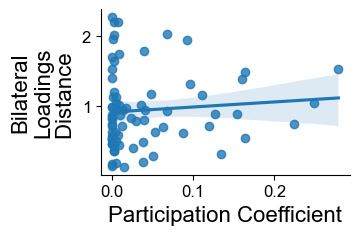

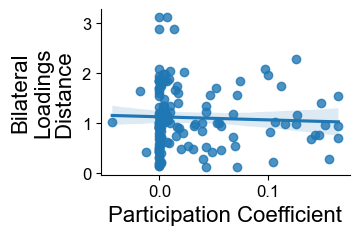

In [492]:
plot = sns.lmplot(x = "Networked_Laterality", y = "Functional_Laterality", data = unidmodal_df[(unidmodal_df['Laterality'] == 'Lateral')], aspect = .5, sharex = False, sharey = True)
plot.fig.set_size_inches(4, 2)

plot.fig.suptitle('')
plot.axes[0,0].set_xlabel('Participation Coefficient')
plot.axes[0,0].set_ylabel('Bilateral\nLoadings\nDistance ')

plot = sns.lmplot(x = "Networked_Laterality", y = "Functional_Laterality", data = multimodal_df[(multimodal_df['Laterality'] == 'Lateral')], aspect = .5, sharex = False, sharey = True)
plot.fig.set_size_inches(4, 2)

plot.fig.suptitle('')
plot.axes[0,0].set_xlabel('Participation Coefficient')
plot.axes[0,0].set_ylabel('Bilateral\nLoadings\nDistance ')


# Hemispheric participation coefficient can significantly predict scores on the Math but not the Story task

Our previous findings have demonstrated that Hm coefficients are predictive of the lateralization of multimodal regions. Therefore, Hm coefficients are relevant for understanding how behaviors might be impacted after a lesion. But can we do even better? Can we show that Hm coefficients are directly predictive of behavior? 

Language is lateralized to the left hemisphere. Numerosity is distributed across both hemispheres. Therefore, in the final analysis we test if the Hm coefficients can predict language performance.  

### Section Specific Utility + Plotting Functions

In [461]:
def prepare_data(data):
    data = data[:, features]
    data = np.log(np.add(data, np.abs(np.min(data[np.nonzero(data)])) + np.min(np.abs(data[np.nonzero(data)]))/2))
    return scaler.fit_transform(data)

def estimating_performance(measure, behavior, filter_indices, labels, filter_regions):
    cvo = KFold(n_splits=49, shuffle=True, random_state=42)
    RSME, correlation = [], []
    
    for train, tests in cvo.split(measure):
        X_train, X_tests = measure[train], measure[tests]
        y_train, y_tests = behavior[train], behavior[tests]

        scaler = preprocessing.StandardScaler()

        correlated = np.array([
            stats.pearsonr(X_train[:, i], y_train) if i in filter_indices and i not in filter_regions else [0, 0]
            for i in range(210)
        ])

        features = np.argsort(np.abs(correlated[:, 0]))[-5:]
        
        X_train = prepare_data(X_train)
        X_tests = prepare_data(X_tests)
        
        cvi = KFold(n_splits=4, shuffle=True, random_state=42)
        
        param_grid = {
            'layer_1': range(2, 13),
            'layer_2': range(2, 13),
            'layer_3': range(2, 13),
            'activation': ['relu' , 'tanh'],
            'alpha': (0.0001, 1),
            'momentum' : (0.5, 1.)
        }

        model_cv = RandomizedSearchCV(
            MLPWrapper_3(),
            param_grid,
            n_iter=2000,
            cv=cvi,
            scoring='neg_root_mean_squared_error',
            verbose=1, 
            n_jobs=-1, 
        )
                
        best_model = model_cv.fit(X_train, y_train).best_estimator_
        yhat = best_model.predict(X_tests)

        RSME.append(mean_squared_error(y_tests, yhat, squared=False))
        correlation.append(stats.spearmanr(y_tests, yhat)[0])

    return RSME, correlation

def get_performance_measures(task_name, coef, behavior, indices, filter_regions):
    RMSE = {'lateral': np.zeros((1, 97)), 'normal': np.zeros((1, 97))}
    correlation = {'lateral': np.zeros((1, 2)), 'normal': np.zeros((1, 2))}

    for type in ['lateral', 'normal']:
        RMSE[type], correlation[type] = estimating_performance(
            coef[type],
            behavior[f'Language_Task_{task_name}_Avg_Difficulty_Level'],
            indices[task_name],
            f'{task_name}_{type}_participation',
            filter_regions
        )

    return RMSE, correlation



In [495]:
def plot_RMSE(data, bins, title):
    p_value = permutation_test(data['lateral'], data['normal'], method='approximate', num_rounds=10000, seed=42)
    plt.figure()
    plt.title(title)
    plt.hist(data['lateral'], color=['b'] * 49, bins=bins, label='Hemispheric')
    plt.hist(data['normal'], color=['r'] * 49, bins=bins, label='Whole-Brain')
    plt.axvline(np.nanmean(data['lateral']), color='b', linestyle='--')
    plt.axvline(np.nanmean(data['normal']), color='r', linestyle='--')
    plt.legend()
    plt.show()

def plot_predicted_vs_estimated(prediction_file, empirical_behavior, plot_title):
    predicted = pd.read_pickle(prediction_file)

    df = pd.DataFrame({
        'Empirical': np.repeat(behavior[empirical_behavior], 2),
        'Predicts': np.hstack((predicted['lateral'][4], predicted['normals'][4])),
        'Laterals': ['Lateral'] * 97 + ['Normal'] * 97
    })

    plot = sns.lmplot(data=df, x="Empirical", y="Predicts", hue="Laterals", palette="bright", sharey=False)
    plt.subplots_adjust(wspace=0.25)
    plot.fig.set_size_inches(4, 3)
    plot._legend.remove()

    axes = plot.axes
    axes[0,0].set_title(plot_title)
    axes[0,0].set_xlabel(f"{plot_title.split()[0]} Empirical Scores")
    axes[0,0].set_ylabel(f"{plot_title.split()[0]} Predicted Scores")

### Multilayer Perceptron Parameters

In [430]:
class MLPWrapper_3(BaseEstimator, RegressorMixin):
    
    def __init__(self, layer_1 = 10, layer_2 = 10, layer_3 = 10, activation = 'relu', alpha = 0.0001, learning_rate_init = 0.001, momentum = 0.9):
        self.layer_1 = layer_1
        self.layer_2 = layer_2
        self.layer_3 = layer_3
        self.activation = activation
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.momentum = momentum

    def fit(self, X, y):
        model = MLPRegressor(
            hidden_layer_sizes = [self.layer_1, self.layer_2, self.layer_3],
            activation = self.activation,
            alpha = self.alpha,
            learning_rate = 'adaptive',
            learning_rate_init = self.learning_rate_init,
            solver = 'sgd',
            momentum = self.momentum,
            early_stopping = True,
            random_state = 42, 
            max_iter = 500, 
            n_iter_no_change = 20
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)


### Load data files and set variables

In [446]:
with open('./s900_unrelated.txt') as file:
    subjects = np.array(file.read().splitlines()[0:97]).astype(int)

filter_regions = [52,  53,  55,  56,  59,  67,  75,  90,  94,  95,
   96,  97,  98,  99,  100, 101, 102, 103, 104, 4, 
   26,  28,  29,  32,  33,  35,  36,  37,  65,  72,
   74,  77,  78,  79,  80,  81,  85]

tasks = ['Language_Task_Story_Avg_Difficulty_Level',
         'Language_Task_Math_Avg_Difficulty_Level',
        ]

behavior = pd.read_csv('../../unrestricted_sec036_8_13_2020_2_27_32.csv')
behavior = behavior[behavior.Subject.isin(subjects)][tasks]

behavior = behavior.rename(columns={"Language_Task_Story_Avg_Difficulty_Level": "Language_Task_STORY_Avg_Difficulty_Level",
                                    "Language_Task_Math_Avg_Difficulty_Level": "Language_Task_MATHS_Avg_Difficulty_Level"})

with open('./tasks_indices.pkl', 'rb') as fp:
    tasks_index = pickle.load(fp)

tasks_index['MATHS'] = tasks_index.pop('MATH')


## Analysis

We use a 3-layer multilayer perceptron (MLP) in order to predict the both scores using the Hm and WB coefficients. Because I didn't have prior experience using MLPs and there's no a priori required parameters I used a series of nested cross-validation to optimize the hyper-parameters and estimate the architecture. I used nested cross-validation to ensure absolutely no leaking of information across the training, validation, and test set. The parameters of the MLP are determined in the above section titled 'Multilayer Perceptron Parameters'. This step outputs ```MATHS_RMSE, MATHS_correlation, STORY_RMSE, STORY_correlation``` corresponding to the loss function (RMSE) and an intuitive estimate of performance (correlation).

In [ ]:
MATHS_RMSE, MATHS_correlation = get_performance_measures(
    'MATHS', participation_coef, behavior, tasks_index, filter_regions
)

STORY_RMSE, STORY_correlation = get_performance_measures(
    'STORY', participation_coef, behavior, tasks_index, filter_regions
)


Because going through all the hyper-parameters takes days and I just made this notebook for the assignment, I'm loading the pre-calculated estimates. 

In [405]:
with open('./models/STORY_5_MLPRegressor_PPE_49_folds_3_layers.pkl', 'rb') as fp:
    STORY_5_MLPRegressor_PPE_49_folds_3_layers = pickle.load(fp)

with open('./models/MATHS_5_MLPRegressor_PPE_49_folds_3_layers.pkl', 'rb') as fp:
    MATHS_5_MLPRegressor_PPE_49_folds_3_layers = pickle.load(fp)


STORY_RMSE = {'normal': None, 'lateral': None}
STORY_RMSE['normal'] = STORY_5_MLPRegressor_PPE_49_folds_3_layers['normals']['rmse']
STORY_RMSE['lateral'] = STORY_5_MLPRegressor_PPE_49_folds_3_layers['lateral']['rmse']

MATHS_RMSE = {'normal': None, 'lateral': None}
MATHS_RMSE['normal'] = MATHS_5_MLPRegressor_PPE_49_folds_3_layers['normals']['rmse']
MATHS_RMSE['lateral'] = MATHS_5_MLPRegressor_PPE_49_folds_3_layers['lateral']['rmse']


Ultimately, we care about whether Hm or WB coefficients are better at modeling task scores. One method of statistically testing the performance of Hm and WB coefficients is to compare the loss at each cross-validation fold. Because I used 49 folds the RMSE distribution contains 49 entries. Conducting a permutation test between the RMSE distributions between Hm and WB estimates reveals if a statistical difference exists.

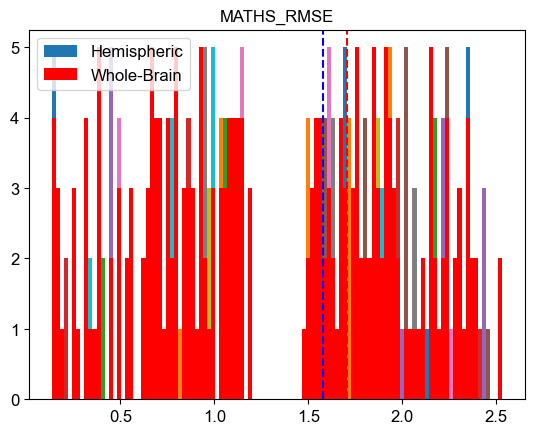

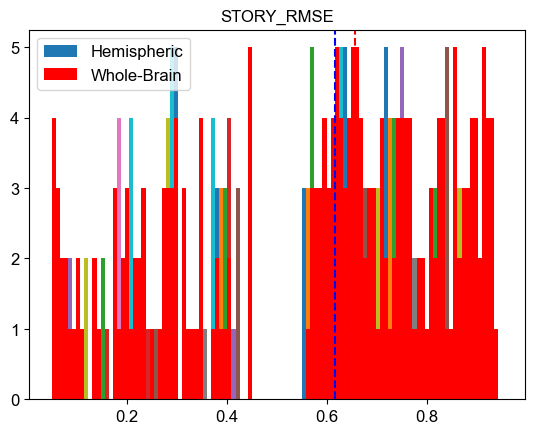

In [496]:
plot_RMSE(MATHS_RMSE, np.arange(0, 4, 4/3), "MATHS_RMSE")
plot_RMSE(STORY_RMSE, np.arange(0, 1.5, 0.5), "STORY_RMSE")

Our permutation tests indicate that RMSE distributions derived from modeling task scores using Hm and WB coefficients are not significantly different on both Maths and Story tasks. 

The above plots are created using cross-validation to get generalizable models. Below, the models are overfit on all the data to maximize accuracy on the already seen task scores.

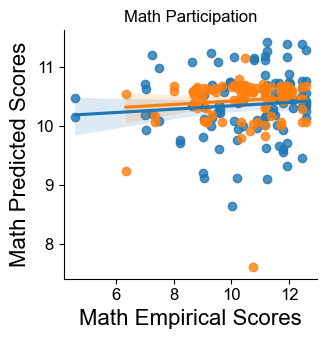

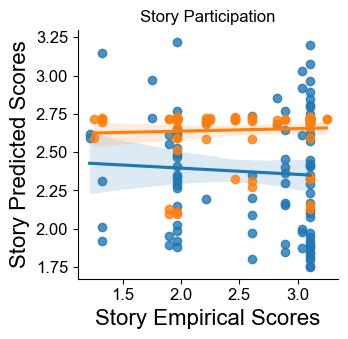

In [494]:
plot_predicted_vs_estimated('./models/MATHS_predicted.pkl', 'Language_Task_STORY_Avg_Difficulty_Level', 'Math Participation')
plot_predicted_vs_estimated('./models/STORY_predicted.pkl', 'Language_Task_MATHS_Avg_Difficulty_Level', 'Story Participation')